## Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import norm
from sklearn.metrics import precision_recall_curve

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

## Setup dataframes etc

In [4]:
leg = ['Alcohol', 'Caff', 'Choc', 'Legalh',  'Nicotine']
ileg = ['Amphet', 'Amyl', 'Benzos', 'Cannabis', 'Coke', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine',  'LSD', 'Meth', 'Mushrooms', 'VSA']
fic = ['Semer']

pers = ['neuroticism', 'extraversion', 'openness', 'agreeableness', 'conscientiousness', 'impulsive', 'sensation', 'intercept']
features = ['age', 'gender', 'education', 'country', 'ethnicity']


df = pd.read_csv('data/raw/data.csv', sep=',', index_col='id')
df.drop(features, axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

df2 = df.copy()

use_mapping = {'CL0': 0, #never used
               'CL1': 0, #over a decade ago
               'CL2': 0, #within the last decade
               'CL3': 1, #within the last year
               'CL4': 1, #within the last month
               'CL5': 1, #within the last week
               'CL6': 1} #within the last day

for j in ['Alcohol', 'Amphet', 'Amyl', 'Benzos', 'Caff', 'Cannabis', 'Choc', 'Coke', 'Crack',
       'Ecstasy', 'Heroin', 'Ketamine', 'Legalh', 'LSD', 'Meth', 'Mushrooms','Nicotine', 'Semer', 'VSA']:
    temp = []
    for i in df[j]:
        temp.append(use_mapping[i])

    df2[j] = temp


df2['any_illeg'] = 0
df2.loc[df2[ileg].sum(axis=1) > 0,'any_illeg'] = 1
df2['intercept'] = 1 #add intercept column for statsmodel

df2.shape


(1885, 28)

In [5]:
##Create a holdout test set for final results

idx = df2.sample(200, replace=False, random_state=42).index

holdout = df2.loc[idx]

df2.drop(idx, inplace=True)

holdout.shape, df2.shape

((200, 28), (1685, 28))

## Helper functions

In [6]:
def logistic(X):
    '''Given X, returns 1/(1+e^X)'''
    return 1/(1 + np.exp(X))

def predictor(clf, X, threshold):
    '''Given a model that predicts probabilities, returns 0-1 predictions with 0.5 threshold'''
    y_pred = clf.predict(X)
    return [0 if a < threshold else 1 for a in y_pred]

In [7]:
drug = 'any_illeg'
X = df2[pers]
y = df2[drug]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [16]:
clf = sm.Logit(y_train, X_train).fit()

clf.summary()

Optimization terminated successfully.
         Current function value: 0.490786
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              any_illeg   No. Observations:                 1348
Model:                          Logit   Df Residuals:                     1340
Method:                           MLE   Df Model:                            7
Date:                Wed, 03 Jan 2024   Pseudo R-squ.:                  0.2584
Time:                        22:43:24   Log-Likelihood:                -661.58
converged:                       True   LL-Null:                       -892.04
Covariance Type:            nonrobust   LLR p-value:                 2.000e-95
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
neuroticism           0.0136      0.081      0.167      0.867      -0.146       0.173
extraversion         -0.4870      0.090     -5.432      0.000      -0.663      -0.311
openness              0.7664      0.083      9.188      0.000       0.603       0.930
agreeableness        -0.1589      0.073     -2.180      0.029      -0.302      -0.016
conscientiousness    -0.4622      0.081     -5.681      0.000      -0.622      -0.303
impulsive             0.0721      0.094      0.763      0.445      -0.113       0.257
sensation             0.8712      0.105      8.332      0.000       0.666       1.076
intercept             0.7427      0.071     10.414      0.000       0.603       0.882
=====================================================================================
"""

In [17]:
y_pred = predictor(clf, X_test, 0.5)

f1_score(y_pred, y_test)

0.8387096774193549

In [18]:
clf = sm.Logit(y_train, X_train.intercept).fit()

clf.summary()
odds_ratios = pd.DataFrame(
    {
        "OR": clf.params,
        "Lower CI": clf.conf_int()[0],
        "Upper CI": clf.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)

odds_ratios

Optimization terminated successfully.
         Current function value: 0.661752
         Iterations 4


,OR,Lower CI,Upper CI
intercept,1.664032,1.49033,1.857978


In [19]:
y_pred = predictor(clf, X_test.intercept, 0.5)

f1_score(y_pred, y_test)

0.7678244972577697

### Interpretation:

p-vals are interesting here, neuroticism and impulsiveness not significant, suggesting these traits are not useful in predicting drug use.

In [102]:
beta = np.array(clf.params).reshape(-1,1)
samp = np.array(X_train.iloc[244]).reshape(1,-1) #get a single samp for testing

logistic(samp@beta)[0][0], 1-clf.predict(samp)[0] #chance of belonging to the '0' class. This is just for my sanity check.

(0.07601666525661571, 0.07601666525661566)

Explaining Odds Ratios: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2938757/ 

Odds ratios are used to compare the relative odds of the occurrence of the outcome of interest (e.g. disease or disorder), given exposure to the variable of interest (e.g. health characteristic, aspect of medical history). The odds ratio can also be used to determine whether a particular exposure is a risk factor for a particular outcome, and to compare the magnitude of various risk factors for that outcome.

OR=1 Exposure does not affect odds of outcome

OR>1 Exposure associated with higher odds of outcome

OR<1 Exposure associated with lower odds of outcome

In [103]:
# code from https://www.andrewvillazon.com/logistic-regression-python-statsmodels/

odds_ratios = pd.DataFrame(
    {
        "OR": clf.params,
        "Lower CI": clf.conf_int()[0],
        "Upper CI": clf.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)

odds_ratios#.to_latex()

,OR,Lower CI,Upper CI
neuroticism,1.013705,0.864167,1.189119
extraversion,0.614461,0.515448,0.732494
openness,2.152106,1.827505,2.534363
agreeableness,0.853101,0.739529,0.984115
conscientiousness,0.629881,0.537040,0.738772
impulsive,1.074798,0.893112,1.293444
sensation,2.389734,1.946944,2.933227
intercept,2.101501,1.827386,2.416736


We can interpret the odds ratios as for a 1 unit increase in neurotictism, the prob of taking any illicit drug decreases by 9% (100*(0.91 - 1))


In [104]:
y_pred = predictor(clf, X_test, 0.5)

f1_score(y_pred, y_test)

0.8387096774193549

In [105]:
drug_df = pd.DataFrame(index=pers[:-1])

Optimization terminated successfully.
         Current function value: 0.490786
         Iterations 6
Drug: any_illeg
F1 score: 0.839
                          OR  Lower CI  Upper CI     coefs  p_values
neuroticism        1.013705  0.864167  1.189119  0.013612     0.867
extraversion       0.614461  0.515448  0.732494 -0.487010     0.000
openness           2.152106  1.827505  2.534363  0.766447     0.000
agreeableness      0.853101  0.739529  0.984115 -0.158877     0.029
conscientiousness  0.629881  0.537040  0.738772 -0.462224     0.000
impulsive          1.074798  0.893112  1.293444  0.072133     0.445
sensation          2.389734  1.946944  2.933227  0.871182     0.000
intercept          2.101501  1.827386  2.416736  0.742652     0.000


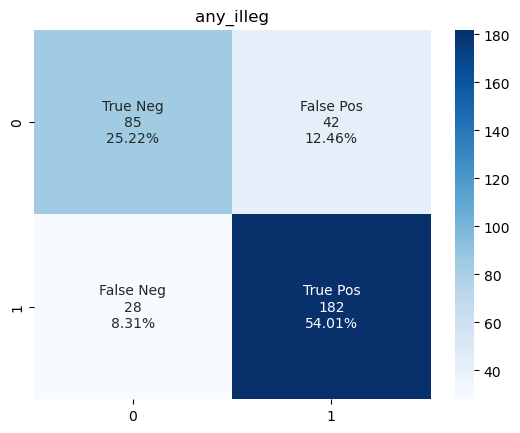

In [106]:
drug = 'any_illeg'

y = df2[drug]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clf = sm.Logit(y_train, X_train).fit()

#print(clf.summary())

odds_ratios = pd.DataFrame(
    {
        "OR": clf.params,
        "Lower CI": clf.conf_int()[0],
        "Upper CI": clf.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)

odds_ratios['coefs'] = clf.params
odds_ratios['p_values'] = clf.pvalues.round(3)



y_pred = predictor(clf, X_test, 0.5)
cm = confusion_matrix(y_test, y_pred)

print(f'Drug: {drug}\nF1 score: {f1_score(y_pred, y_test):.3}\n {odds_ratios}')

_, axes = plt.subplots(1,1)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
axes.set_title(f'{drug}')
axes.set_xlabel('predicted')
axes.set_ylabel('true')
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=axes);

In [107]:
def stats(drug, drug_df):
    y = df2[drug]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    clf = sm.Logit(y_train, X_train).fit(disp=0)

    odds_ratios = pd.DataFrame(
        {
            "OR": clf.params,
            "Lower CI": clf.conf_int()[0],
            "Upper CI": clf.conf_int()[1],
        }
    )
    odds_ratios = np.exp(odds_ratios)

    odds_ratios['coefs'] = clf.params
    odds_ratios['p_values'] = clf.pvalues.round(3)

    y_pred = predictor(clf, X_test, 0.5)
    drug_df[drug] = abs(1-odds_ratios['OR']).T #finds difference from 1 of the OR
    drug_df.loc['F1', drug] = f1_score(y_pred, y_test)

    return drug_df

In [108]:
for drug in ['any_illeg']+ileg +leg:
    drug_df = stats(drug, drug_df)

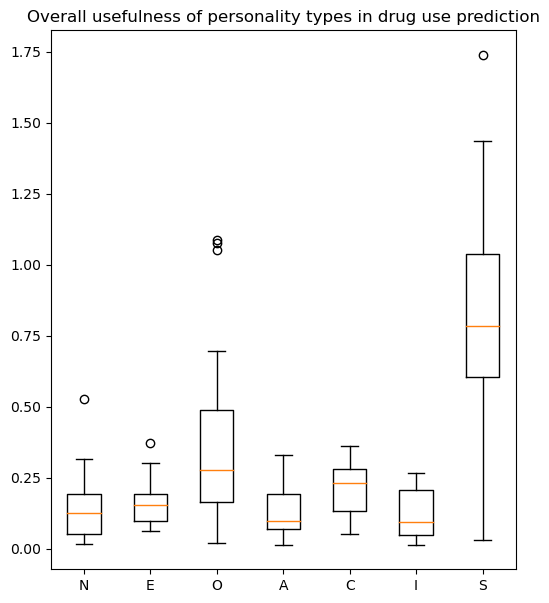

In [109]:
_, ax = plt.subplots(1,1, figsize=(6,7))

ax.boxplot(drug_df[leg+ileg].T[pers[:-1]], labels=[x[0].upper() for x in pers[:-1]])
ax.set_title('Overall usefulness of personality types in drug use prediction');

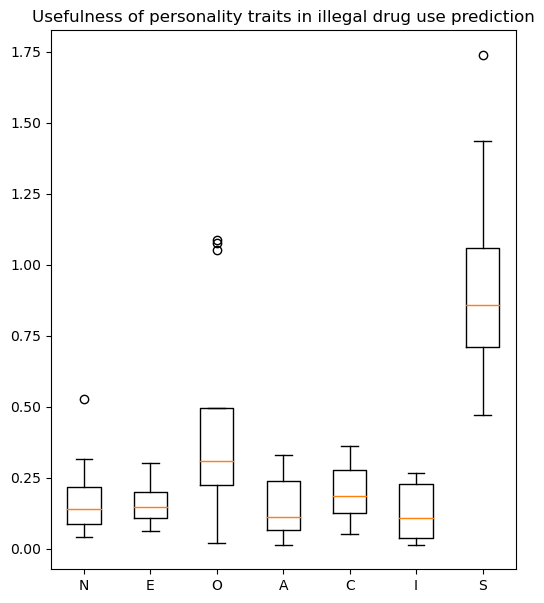

In [110]:
_, ax = plt.subplots(1,1, figsize=(6,7))

ax.boxplot(drug_df[ileg].T[pers[:-1]], labels=[x[0].upper() for x in pers[:-1]])
ax.set_title('Usefulness of personality traits in illegal drug use prediction');

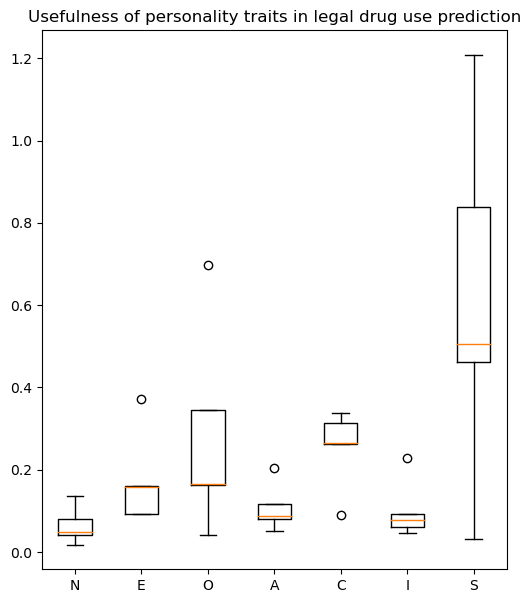

In [111]:
_, ax = plt.subplots(1,1, figsize=(6,7))

ax.boxplot(drug_df[leg].T[pers[:-1]], labels=[x[0].upper() for x in pers[:-1]])
ax.set_title('Usefulness of personality traits in legal drug use prediction');

### What we've learnt:

Personality traits are useful in predicting drug use in some drugs

In [18]:
ileg + leg

['Amphet',
 'Amyl',
 'Benzos',
 'Cannabis',
 'Coke',
 'Crack',
 'Ecstasy',
 'Heroin',
 'Ketamine',
 'LSD',
 'Meth',
 'Mushrooms',
 'VSA',
 'Alcohol',
 'Caff',
 'Choc',
 'Legalh',
 'Nicotine']

In [112]:
#pvals = {}

In [391]:
drug = 'any_illeg'
X = df2[pers]
y = df2[drug]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clf = sm.Logit(y_train, X_train).fit()

clf.summary()

Optimization terminated successfully.
         Current function value: 0.490786
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              any_illeg   No. Observations:                 1348
Model:                          Logit   Df Residuals:                     1340
Method:                           MLE   Df Model:                            7
Date:                Wed, 03 Jan 2024   Pseudo R-squ.:                  0.2584
Time:                        16:15:29   Log-Likelihood:                -661.58
converged:                       True   LL-Null:                       -892.04
Covariance Type:            nonrobust   LLR p-value:                 2.000e-95
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
neuroticism           0.0136      0.081      0.167      0.867      -0.146       0.173
extraversion         -0.4870      0.090     -5.432      0.000      -0.663      -0.311
openness              0.7664      0.083      9.188      0.000       0.603       0.930
agreeableness        -0.1589      0.073     -2.180      0.029      -0.302      -0.016
conscientiousness    -0.4622      0.081     -5.681      0.000      -0.622      -0.303
impulsive             0.0721      0.094      0.763      0.445      -0.113       0.257
sensation             0.8712      0.105      8.332      0.000       0.666       1.076
intercept             0.7427      0.071     10.414      0.000       0.603       0.882
=====================================================================================
"""

In [392]:
probs = clf.predict(X_test)

precision, recall, thresholds = precision_recall_curve(y_test, probs)

f1s = 2*(precision*recall)/(precision+recall)

In [393]:
'''sns.scatterplot(x=precision[:-1], y=recall[:-1], label='precision vs recall')
sns.scatterplot(y=f1s[:-1],x=precision[:-1], label='F1 score')
plt.xlabel('precision')
plt.ylabel('recall')''';

In [394]:
f1s = f1s[~np.isnan(f1s)] #remove invalid F1 scores where precision/recall = 0

#Prints max F1 score and its associated precision, recall and threshold
print(f'max F1:{f1s[f1s.argmax()]}\nprecision: {precision[f1s.argmax()]}\nrecall: {recall[f1s.argmax()]}\nthreshold: {thresholds[f1s.argmax()]}')


max F1:0.8616071428571427
precision: 0.8109243697478992
recall: 0.919047619047619
threshold: 0.4627635037087486


Drug: any_illeg
F1 score: 0.834


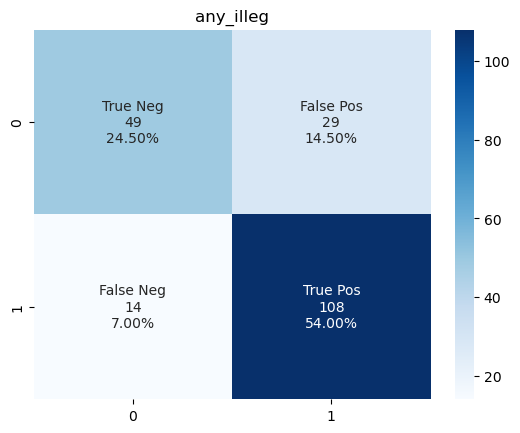

In [395]:
#now we can test against the holdout test set

X_hold = holdout[pers]
y_hold = holdout[drug]

y_pred = predictor(clf, X_hold, thresholds[f1s.argmax()])
cm = confusion_matrix(y_hold, y_pred)

print(f'Drug: {drug}\nF1 score: {f1_score(y_pred, y_hold):.3}')
F1 = f1_score(y_pred, y_hold)
_, axes = plt.subplots(1,1)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
axes.set_title(f'{drug}')
axes.set_xlabel('predicted')
axes.set_ylabel('true')
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=axes);

## Create a null model to test against


In [396]:
def rand_classifier(X, y_train):
    '''randomly assigns to a class depending on the training class probabilities'''
    p = y_train.sum()/ y_train.shape[0] # percentage positive in training set.

    y_pred = []

    for _ in X.values:
        if np.random.random() >= p:
            y_pred.append(0)
        else:
            y_pred.append(1)

    return np.array(y_pred)


In [397]:
y_pred = rand_classifier(X_hold, y_train)

print(f'Drug: {drug}\nF1 score: {f1_score(y_pred, y_hold):.3}') # a single test isn't sufficient, but we can make multiple tests to create a confidence interval.

Drug: any_illeg
F1 score: 0.618


In [398]:
n = 10000
av_f1 = []
np.random.seed(42)

for _ in range(n):
    y_pred = rand_classifier(X_hold, y_train)
    av_f1.append(f1_score(y_pred, y_hold))
    

    
mu, std = norm.fit(av_f1)

print(f'Mean:{sum(av_f1)/n}\nConfidence interval: {np.percentile(av_f1, 2.5):.3f}, {np.percentile(av_f1, 97.5):.3f}\nprob of getting F1 of {F1:.3}: {norm.sf(F1,mu,std):.15f}')

Mean:0.6166014974580281
Confidence interval: 0.553, 0.677
prob of getting F1 of 0.834: 0.000000000007150


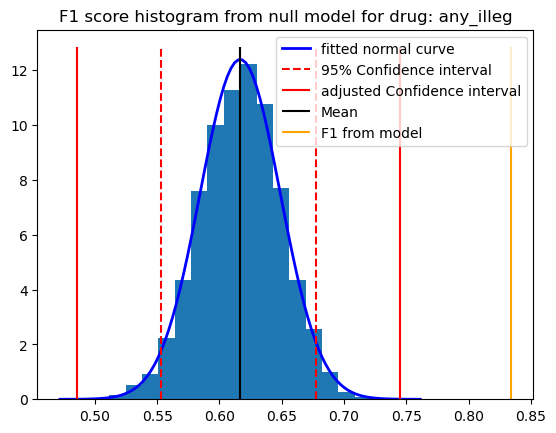

In [399]:
plt.hist(av_f1,bins=20, density=True)
ymin, ymax = plt.ylim()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'blue', linewidth=2, label='fitted normal curve')

adj_p = 0.05/19


plt.vlines(x=[np.percentile(av_f1, 2.5),np.percentile(av_f1, 100-2.5)], ymin=ymin, ymax=ymax, color='r', linestyles='dashed', label='95% Confidence interval')
plt.vlines(x=[np.percentile(av_f1, adj_p/2),np.percentile(av_f1, 100-(adj_p/2))], ymin=ymin, ymax=ymax, color='r', label='adjusted Confidence interval')
plt.vlines(x=[sum(av_f1)/n], ymin=ymin, ymax=ymax, color='k', label='Mean')
plt.vlines(x=F1, ymin=ymin, ymax=ymax, color='orange', label='F1 from model')
plt.title(f'F1 score histogram from null model for drug: {drug}')
plt.legend();

In [400]:
#pvals[drug] = norm.sf(F1,mu,std)
print(f'{drug} & {F1:.3} & {norm.sf(F1,mu,std):.3} & {np.percentile(av_f1, 2.5):.3f} & {np.percentile(av_f1, 97.5):.3f}\\\\ ')

any_illeg & 0.834 & 7.15e-12 & 0.553 & 0.677\\ 


Drug        & F1    & p-val     & CI_L  & CI_U \\
any_illeg   & 0.834 & 7.15e-12  & 0.553 & 0.677\\
Amphet      & 0.496 & 2.7e-07   & 0.106 & 0.326\\ 
Amyl        & 0.207 & 0.02      & 0.000 & 0.222\\
Benzos      & 0.526 & 3.62e-06  & 0.189 & 0.391\\
Cannabis    & 0.761 & 5.19e-10  & 0.453 & 0.602\\
Coke        & 0.512 & 9.46e-08  & 0.103 & 0.327\\
Crack       & 0.133 & 0.0578    & 0.000 & 0.200\\ 
Ecstasy     & 0.603 & 7.06e-10  & 0.170 & 0.383\\
Heroin      & 0.421 & 3.82e-08  & 0.000 & 0.214\\  
Ketamine    & 0.34 & 0.000119   & 0.000 & 0.245\\
LSD         & 0.585 & 4.21e-11  & 0.098 & 0.322\\
Meth        & 0.359 & 0.000593  & 0.058 & 0.286\\
Mushrooms   & 0.613 & 1.99e-11  & 0.132 & 0.355\\
VSA         & 0.145 & 0.0796    & 0.000 & 0.211\\
Alcohol     & 0.958 & 0.00262   & 0.907 & 0.947\\ 
Caff        & 0.985 & 0.00809   & 0.953 & 0.980\\
Choc        & 0.992 & 0.0148    & 0.966 & 0.990\\
Legalh      & 0.601 & 1.81e-09  & 0.187 & 0.393\\
Nicotine    & 0.694 & 5.48e-05  & 0.481 & 0.623\\

In [331]:
#pvals

{'any_illeg': 7.149598406138443e-12,
 'Amphet': 2.702971882472969e-07,
 'Amyl': 0.019950486691374992,
 'Benzos': 3.61820152467574e-06,
 'Cannabis': 5.188509451408089e-10,
 'Coke': 9.462715526112852e-08,
 'Crack': 0.05778062777749145,
 'Ecstasy': 7.064193542819692e-10,
 'Heroin': 3.8241213270669805e-08,
 'Ketamine': 0.00011868575327055259,
 'LSD': 4.209288711509467e-11,
 'Meth': 0.0005932267693414237,
 'Mushrooms': 1.9924835167592334e-11,
 'VSA': 0.07961375770273782,
 'Alcohol': 0.002619372886677695,
 'Caff': 0.008089840891629766,
 'Choc': 0.014795934614839057,
 'Legalh': 1.8144680780574523e-09,
 'Nicotine': 5.4799686354859966e-05}

## Next steps: 

Put this together nicely to calc for each drug. Then calc a correction for multihypothosis testing.

In [332]:
pvals = {'any_illeg': 7.149598406138443e-12,
        'Amphet': 2.702971882472969e-07,
        'Amyl': 0.019950486691374992,
        'Benzos': 3.61820152467574e-06,
        'Cannabis': 5.188509451408089e-10,
        'Coke': 9.462715526112852e-08,
        'Crack': 0.05778062777749145,
        'Ecstasy': 7.064193542819692e-10,
        'Heroin': 3.8241213270669805e-08,
        'Ketamine': 0.00011868575327055259,
        'LSD': 4.209288711509467e-11,
        'Meth': 0.0005932267693414237,
        'Mushrooms': 1.9924835167592334e-11,
        'VSA': 0.07961375770273782,
        'Alcohol': 0.002619372886677695,
        'Caff': 0.008089840891629766,
        'Choc': 0.014795934614839057,
        'Legalh': 1.8144680780574523e-09,
        'Nicotine': 5.4799686354859966e-05}

In [333]:
#Family-wise error rate = 1 – (1-α)n
alp = 0.05
n=len(pvals.keys())

1 - ((1-alp)**n) #There is a high likelihood of making a type 1 error, ie concluding there is a relationship when one doesn't really exist

0.6226463974646927

In [334]:
#Bonferroni correction

alp_new = alp/n

alp_new

0.002631578947368421

In [335]:
users = pd.DataFrame(columns=['users%'])

for i in leg+ileg+['any_illeg']:
    #temp = [i,df2[i].sum(axis=0)/df2.shape[0]]
    users.loc[i] = round(100*df2[i].sum(axis=0)/df2.shape[0], 2)

In [336]:
for k,v in pvals.items():
    if v <= alp_new:
        print(f'{k}: significant, pval: {v}')

any_illeg: significant, pval: 7.149598406138443e-12
Amphet: significant, pval: 2.702971882472969e-07
Benzos: significant, pval: 3.61820152467574e-06
Cannabis: significant, pval: 5.188509451408089e-10
Coke: significant, pval: 9.462715526112852e-08
Ecstasy: significant, pval: 7.064193542819692e-10
Heroin: significant, pval: 3.8241213270669805e-08
Ketamine: significant, pval: 0.00011868575327055259
LSD: significant, pval: 4.209288711509467e-11
Meth: significant, pval: 0.0005932267693414237
Mushrooms: significant, pval: 1.9924835167592334e-11
Alcohol: significant, pval: 0.002619372886677695
Legalh: significant, pval: 1.8144680780574523e-09
Nicotine: significant, pval: 5.4799686354859966e-05


In [337]:
for k,v in pvals.items():
    if v > alp_new:
        print(f'{k}: Not significant, pval: {v}')

Amyl: Not significant, pval: 0.019950486691374992
Crack: Not significant, pval: 0.05778062777749145
VSA: Not significant, pval: 0.07961375770273782
Caff: Not significant, pval: 0.008089840891629766
Choc: Not significant, pval: 0.014795934614839057


In [343]:
#Benjamini Hochberg thing... 
from statsmodels.stats.multitest import fdrcorrection

reject, adj_pvals = fdrcorrection(list(pvals.values()), alpha=0.05, method='indep', is_sorted=False)

array([1.35842370e-10, 5.70627397e-07, 2.22976028e-02, 6.87458290e-06,
       2.46454199e-09, 2.24739494e-07, 6.09906627e-02, 2.68439355e-09,
       1.03797579e-07, 1.87919109e-04, 2.66588285e-10, 8.67023740e-04,
       1.89285934e-10, 7.96137577e-02, 3.55486320e-03, 1.02471318e-02,
       1.75701724e-02, 5.74581558e-09, 9.46540037e-05])

In [345]:
c = pd.DataFrame(pvals.items(), columns=['Drug', 'pval'])

c[~reject] #this method only suggests 2 not significant results.

,Drug,pval
6,Crack,0.057781
13,VSA,0.079614


In [349]:
np.random.seed(42)
np.random.random()

0.3745401188473625

In [132]:
def log_run(drug):
    '''bootstraps a sample and returns the sample F1 score'''
    df = df2.sample(df2.shape[0],replace=True)

    X = df[pers]
    y = df[drug]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    clf = sm.Logit(y_train, X_train).fit(disp=0)

    probs = clf.predict(X_test)

    precision, recall, thresholds = precision_recall_curve(y_test, probs)

    f1s = 2*(precision*recall)/(precision+recall)

    f1s = f1s[~np.isnan(f1s)] #remove invalid F1 scores where precision/recall = 0

    X_hold = holdout[pers]
    y_hold = holdout[drug]

    y_pred = predictor(clf, X_hold, thresholds[f1s.argmax()])
    cm = confusion_matrix(y_hold, y_pred)

    F1 = f1_score(y_pred, y_hold)   

    return F1

In [379]:
log_df = pd.DataFrame(index=[['any_illeg']+leg+ileg], columns=[i for i in range(1000)])
np.random.seed(42)

for drug in ['any_illeg']+leg+ileg:
    f1s = []

    for _ in range(1000):
        F1 = log_run(drug)
        f1s.append(F1)
    log_df.loc[drug] = f1s #This cell takes a while to run ~5mins on my machine.

/tmp/ipykernel_666/2987853285.py:16: RuntimeWarning: invalid value encountered in divide
  f1s = 2*(precision*recall)/(precision+recall)
/tmp/ipykernel_666/2987853285.py:16: RuntimeWarning: invalid value encountered in divide
  f1s = 2*(precision*recall)/(precision+recall)
/tmp/ipykernel_666/2987853285.py:16: RuntimeWarning: invalid value encountered in divide
  f1s = 2*(precision*recall)/(precision+recall)
/tmp/ipykernel_666/2987853285.py:16: RuntimeWarning: invalid value encountered in divide
  f1s = 2*(precision*recall)/(precision+recall)
/tmp/ipykernel_666/2987853285.py:16: RuntimeWarning: invalid value encountered in divide
  f1s = 2*(precision*recall)/(precision+recall)
/tmp/ipykernel_666/2987853285.py:16: RuntimeWarning: invalid value encountered in divide
  f1s = 2*(precision*recall)/(precision+recall)
/tmp/ipykernel_666/2987853285.py:16: RuntimeWarning: invalid value encountered in divide
  f1s = 2*(precision*recall)/(precision+recall)
/tmp/ipykernel_666/2987853285.py:16: Runt

In [381]:
log_df.T.mean()

any_illeg    0.819701
Alcohol      0.961085
Caff         0.982682
Choc         0.991673
Legalh       0.599228
Nicotine     0.688596
Amphet       0.504970
Amyl         0.201764
Benzos       0.532888
Cannabis     0.767619
Coke         0.510105
Crack        0.132217
Ecstasy      0.606216
Heroin       0.326470
Ketamine     0.363506
LSD          0.517439
Meth         0.390870
Mushrooms    0.614914
VSA          0.115503
dtype: float64

In [351]:
#F1 scores from logistic regression trained on X_train

train_f1 = {'any_illeg':0.834,
            'Amphet':0.496, 
            'Amyl':0.207,
            'Benzos':0.526,
            'Cannabis':0.761,
            'Coke':0.512,
            'Crack':0.133,
            'Ecstasy':0.603,
            'Heroin':0.421, 
            'Ketamine': 0.34,
            'LSD': 0.585,
            'Meth': 0.359,
            'Mushrooms':0.613,
            'VSA': 0.145,
            'Alcohol':0.958, 
            'Caff':0.985,
            'Choc': 0.992,
            'Legalh':0.601,
            'Nicotine': 0.694}

In [382]:
#Comparison of F1 scores from bootstrapped training sets I don't think this is actually very useful.

for drug in ['any_illeg']+leg+ileg:
    print(f'{drug}:\n\ttrainF1: {train_f1[drug]}\n\tboot F1: {log_df.T.mean()[drug]:.3}\n\tDiff   : {abs(train_f1[drug] - log_df.T.mean()[drug]):.3}')

any_illeg:
	trainF1: 0.834
	boot F1: 0.82
	Diff   : 0.166
Alcohol:
	trainF1: 0.958
	boot F1: 0.961
	Diff   : 0.042
Caff:
	trainF1: 0.985
	boot F1: 0.983
	Diff   : 0.015
Choc:
	trainF1: 0.992
	boot F1: 0.992
	Diff   : 0.008
Legalh:
	trainF1: 0.601
	boot F1: 0.599
	Diff   : 0.399
Nicotine:
	trainF1: 0.694
	boot F1: 0.689
	Diff   : 0.306
Amphet:
	trainF1: 0.496
	boot F1: 0.505
	Diff   : 0.504
Amyl:
	trainF1: 0.207
	boot F1: 0.202
	Diff   : 0.207
Benzos:
	trainF1: 0.526
	boot F1: 0.533
	Diff   : 0.474
Cannabis:
	trainF1: 0.761
	boot F1: 0.768
	Diff   : 0.239
Coke:
	trainF1: 0.512
	boot F1: 0.51
	Diff   : 0.488
Crack:
	trainF1: 0.133
	boot F1: 0.132
	Diff   : 0.133
Ecstasy:
	trainF1: 0.603
	boot F1: 0.606
	Diff   : 0.397
Heroin:
	trainF1: 0.421
	boot F1: 0.326
	Diff   : 0.421
Ketamine:
	trainF1: 0.34
	boot F1: 0.364
	Diff   : 0.34
LSD:
	trainF1: 0.585
	boot F1: 0.517
	Diff   : 0.415
Meth:
	trainF1: 0.359
	boot F1: 0.391
	Diff   : 0.359
Mushrooms:
	trainF1: 0.613
	boot F1: 0.615
	Diff   : 0.

In [2]:
X = df2[pers]
y = df2[drug]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clf = sm.Logit(y_train, X_train).fit(disp=0)

probs = clf.predict(X_test)

NameError: name 'df2' is not defined